In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import thor.data as data
import thor.attribute as attribute
import thor.write as write
import windrose


import thor.visualize as visualize
import thor.config as config

notebook_name = "gridrad_demo.ipynb"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Aggregate data across runs

base_local = config.get_outputs_directory()

pattern = str(base_local / "runs/gridrad_severe/gridrad_2010*[!.tar.gz]")
run_directories = sorted(glob.glob(pattern))
analysis_directory = base_local / "runs/gridrad_severe/analysis"

names = ["core", "group", "core", "core", "ellipse", "profile", "tag", "classification"]
names += ["quality", "velocities"]
dataset_names = ["mcs_core", "group", "convective_core", "anvil_core", "ellipse"]
dataset_names += ["profile", "tag", "classification"]
dataset_names += ["quality", "velocities"]
subdirectories = ["attributes/mcs"] * 2 + ["attributes/mcs/convective"]
subdirectories += ["attributes/mcs/anvil"]
subdirectories += ["attributes/mcs/convective"]
subdirectories += ["attributes/mcs/era5_pl", "attributes/mcs/era5_sl"]
subdirectories += ["analysis"] * 3

In [3]:
dfs = {}

for i, name in enumerate(names):
    df_list = []
    # Read the first file to get the metadata
    filepath = Path(run_directories[0]) / subdirectories[i] / f"{name}.csv"
    attr = attribute.utils.read_metadata_yml(filepath.with_suffix(".yml"))
    for directory in run_directories:
        options_filepath = Path(directory) / "options/data.yml"
        with open(options_filepath, "r") as f:
            data_options = data.option.DataOptions(**yaml.safe_load(f))
        gridrad_options = data_options.dataset_by_name("gridrad")
        event_start = gridrad_options.event_start

        filepath = Path(directory) / subdirectories[i] / f"{name}.csv"
        df = attribute.utils.read_attribute_csv(filepath)
        df["event_start"] = event_start
        df_list.append(df)

    df = pd.concat(df_list)
    df = df.reset_index().set_index(["time", "universal_id", "event_start"])
    df = df.sort_index()
    write.attribute.write_csv(analysis_directory / f"{dataset_names[i]}.csv", df, attr)
    dfs[dataset_names[i]] = df

In [9]:
# Get new objects based on merge/split history?
core = dfs["mcs_core"]
core = core.xs("2010-01-20", level="event_start")
core


latitude  longitude     area parents  \
time                universal_id                                         
2010-01-20 18:00:00 1              30.8229   270.1562    598.6     NaN   
                    2              31.6979   270.6979    981.0     NaN   
2010-01-20 18:10:00 1              30.8229   270.2396    589.3     NaN   
                    2              31.6979   270.8021   1053.8     NaN   
2010-01-20 18:20:00 1              30.8021   270.2604    736.9     NaN   
...                                    ...        ...      ...     ...   
2010-01-21 03:10:00 15             34.0521   266.7188  49047.7     NaN   
                    31             34.7188   261.8021   2668.1     NaN   
                    36             31.5104   270.1979   3177.4     NaN   
2010-01-21 03:20:00 15             33.9688   266.9271  50486.0      36   
                    31             34.7396   261.8854   2865.8     NaN   

                                  u_flow  v_flow  u_displacement  \
time                universal_id                                   
2010-01-20 18:00:00 1                8.3     7.7            13.3   
                    2                9.9     3.9            16.5   
2010-01-20 18:10:00 1               10.0     7.7             3.3   
                    2                9.9     7.7             NaN   
2010-01-20 18:20:00 1               10.0     7.7            23.3   
...                                  ...     ...             ...   
2010-01-21 03:10:00 15              19.2     3.9            32.1   
                    31              15.9     7.7            12.7   
                    36              13.2    11.6             NaN   
2010-01-21 03:20:00 15              16.0     3.9           -19.2   
                    31              15.9     7.7            12.7   

                                  v_displacement  
time                universal_id                  
2010-01-20 18:00:00 1                        0.0  
                    2                        0.0  
2010-01-20 18:10:00 1                       -3.8  
                    2                        NaN  
2010-01-20 18:20:00 1                        7.7  
...                                          ...  
2010-01-21 03:10:00 15                     -15.4  
                    31                       3.9  
                    36                       NaN  
2010-01-21 03:20:00 15                      38.5  
                    31                      11.6  

[273 rows x 8 columns]

In [ ]:

grouped_objects = {}
grouped_ids = []
# Loop backwards through array. Create new objects, looking up parents as needed
times = sorted(np.unique(core.reset_index().time))[::-1]
for time in times:
    objects = core.loc[time].universal_id.unique()
    for obj in objects:
        if obj not in grouped_ids:
            # New object
            grouped_ids.append(obj)
            grouped_objects[obj] = obj
    


In [5]:
quality = dfs["quality"]
classification = dfs["classification"]
raw_sample = quality[["duration", "parents"]].any(axis=1)
system_contained = ["convective_contained", "anvil_contained"]
quality_dispatcher = {
    "velocity": system_contained + ["velocity"],
    "relative_velocity": system_contained + ["relative_velocity"],
    "offset": system_contained + ["offset", "duration"],
    "orientation": ["convective_contained", "anvil_contained", "axis_ratio"],
}

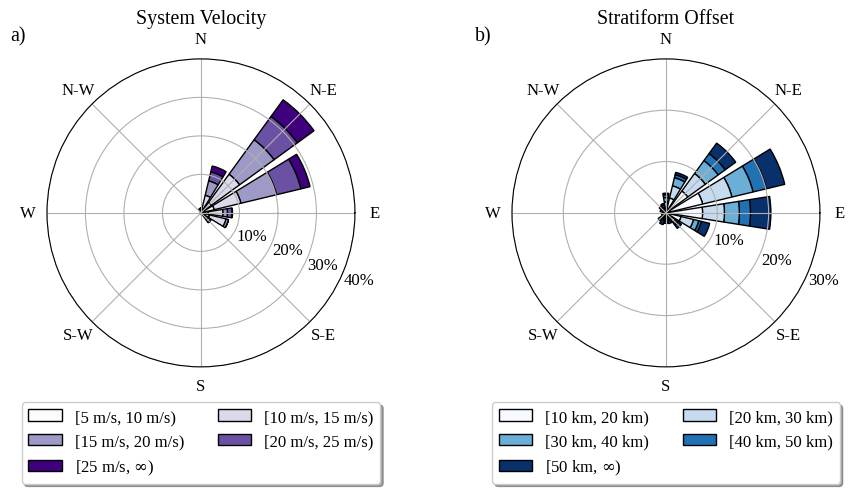

In [84]:
# Basic statistics

style = "paper"

with plt.style.context(
    visualize.visualize.styles[style]
), visualize.visualize.set_style(style):
    kwargs = {"subplot_width": 4, "rows": 1, "columns": 2, "projections": "windrose"}
    kwargs.update({"colorbar": False, "legend_rows": 5, "horizontal_spacing": 2})
    panelled_layout = visualize.horizontal.Panelled(**kwargs)
    fig, subplot_axes, colorbar_axes, legend_ax = panelled_layout.initialize_layout()

    names = quality_dispatcher["velocity"]
    quality = dfs["quality"][names].all(axis=1)
    values = []
    for v in ["u", "v"]:
        values.append(dfs["velocities"][v].where(quality & raw_sample).dropna().values)
    u, v = values
    bins = np.arange(5, 30, 5)
    yticks = np.arange(10, 50, 10)
    colormap = plt.get_cmap("Purples", len(bins))
    kwargs = {"bins": bins, "yticks": yticks, "colormap": colormap}
    kwargs.update({"label_angle": -22.5})
    kwargs.update({"horizontalalignment": "left", "verticalalignment": "top"})
    visualize.analysis.windrose(subplot_axes[0], u, v, **kwargs)
    subplot_axes[0].set_title("System Velocity")
    visualize.analysis.windrose_legend(legend_ax[0], bins, colormap, columns=2)

    names = quality_dispatcher["offset"]
    quality = dfs["quality"][names].all(axis=1)
    values = []
    for v in ["x_offset", "y_offset"]:
        values.append(dfs["group"][v].where(quality & raw_sample).dropna().values)  
    x_offset, y_offset = values
    bins = np.arange(10, 60, 10)
    yticks = np.arange(10, 40, 10)
    colormap = plt.get_cmap("Blues", len(bins))
    kwargs = {"bins": bins, "yticks": yticks, "colormap": colormap}
    kwargs.update({"label_angle": -22.5, "yticks": yticks})
    kwargs.update({"horizontalalignment": "left", "verticalalignment": "top"})
    visualize.analysis.windrose(subplot_axes[1], x_offset, y_offset, **kwargs)
    subplot_axes[1].set_title("Stratiform Offset")
    visualize.analysis.windrose_legend(legend_ax[1], bins, colormap, columns=2, units="km")
    plt.show()

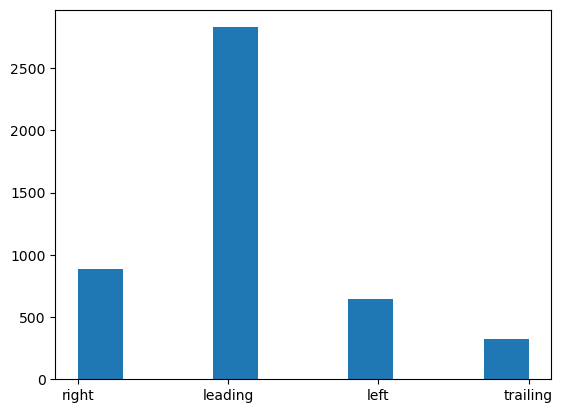

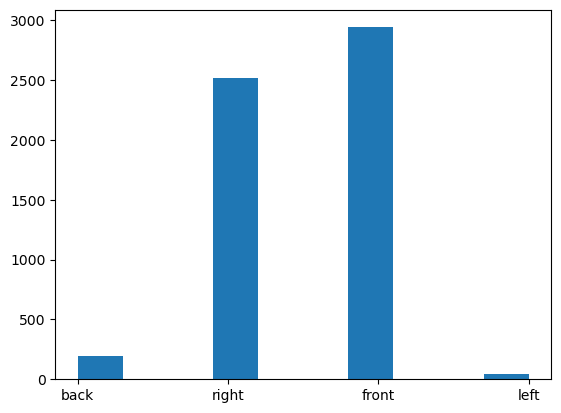

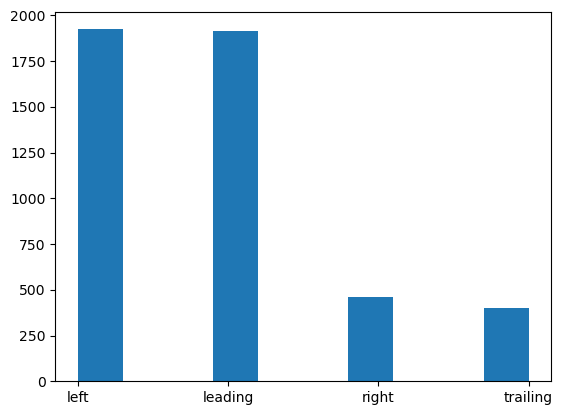

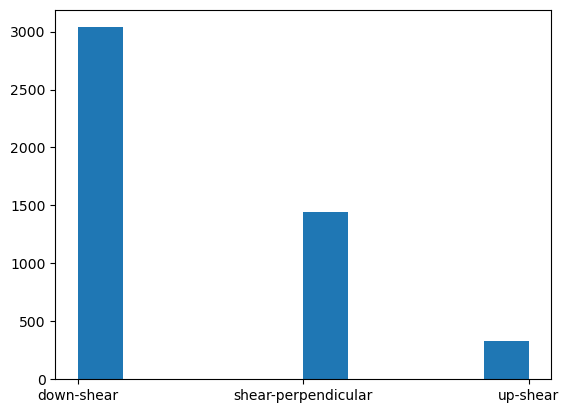

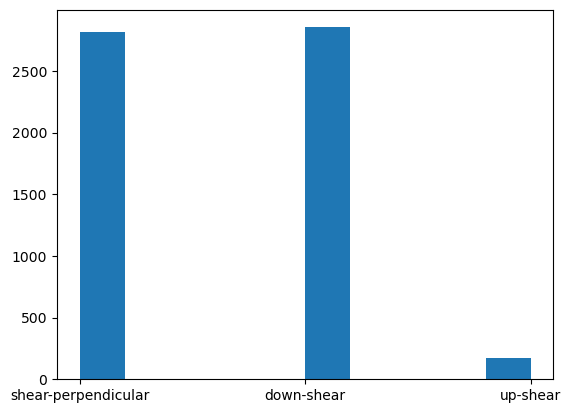

In [89]:
names = ["convective_contained", "anvil_contained", "velocity", "offset"]
stratiform_offset_sample = raw_sample & dfs["quality"][names].all(axis=1)
fig, ax = plt.subplots()
ax.hist(
    classification["stratiform_offset"].where(stratiform_offset_sample).dropna().values
)

names = ["convective_contained", "anvil_contained", "velocity", "relative_velocity"]
inflow_sample = raw_sample & dfs["quality"][names].all(axis=1)
fig, ax = plt.subplots()
ax.hist(classification["inflow"].where(inflow_sample).dropna().values)

names = ["convective_contained", "anvil_contained", "relative_velocity", "offset"]
relative_stratiform_offset_sample = raw_sample & dfs["quality"][names].all(axis=1)
fig, ax = plt.subplots()
ax.hist(
    classification["relative_stratiform_offset"]
    .where(relative_stratiform_offset_sample)
    .dropna()
    .values
)

names = ["convective_contained", "anvil_contained", "shear", "offset"]
shear_sample = raw_sample & dfs["quality"][names].all(axis=1)
fig, ax = plt.subplots()
ax.hist(classification["tilt"].where(shear_sample).dropna().values)

names = ["convective_contained", "anvil_contained", "shear", "relative_velocity"]
propagation_sample = raw_sample & dfs["quality"][names].all(axis=1)
fig, ax = plt.subplots()
ax.hist(classification["propagation"].where(propagation_sample).dropna().values)
plt.show()